# Text processing
Objective: clean and process customers comments to prepare the modelisation with Recurrent Neural Networks and other Deep Learning models

##  Required Libraries

In [18]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import re
import nltk
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


## Load and prepare the data

### Load the data

In [3]:
# load the data
data = pd.read_csv("redoute_v3.csv")
data.head(2)

,id,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,...,year_of_transaction,month_of_transaction,day_of_transaction,weekday_of_transaction,transaction_in_weekend,transaction_date,comment_length,log_comment_length,title_length,nb_days_before_review
0,rev-cc907a30-4fb0-4e55-a4a1-307b89eb0d99,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,...,2023,9,23,5,1,2023-09-23,1049,6.955593,7,12.0
1,rev-b54467c4-4769-42e3-a74a-c72c000059f9,4,Jolie table mais plus pour 6 que pour 8,Livraison impeccable avec possibilité de prend...,2023-10-02 13:08:27,2023-09-11,NaN,NaN,2023-10-02,2023,...,2023,9,11,0,0,2023-09-11,885,6.785588,39,21.0


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23469 entries, 0 to 23468
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      23469 non-null  object 
 1   rating                  23469 non-null  int64  
 2   title                   23469 non-null  object 
 3   comment                 23469 non-null  object 
 4   createdAt               23469 non-null  object 
 5   transaction             23469 non-null  object 
 6   SupplierReply           4841 non-null   object 
 7   SupplierReplyDate       4841 non-null   object 
 8   date_of_cmt             23469 non-null  object 
 9   year_of_cmt             23469 non-null  int64  
 10  month_of_cmt            23469 non-null  int64  
 11  day_of_cmt              23469 non-null  int64  
 12  weekday_of_cmt          23469 non-null  int64  
 13  cmt_in_weekend          23469 non-null  int64  
 14  hour_of_cmt             23469 non-null

### Focus on "rating"

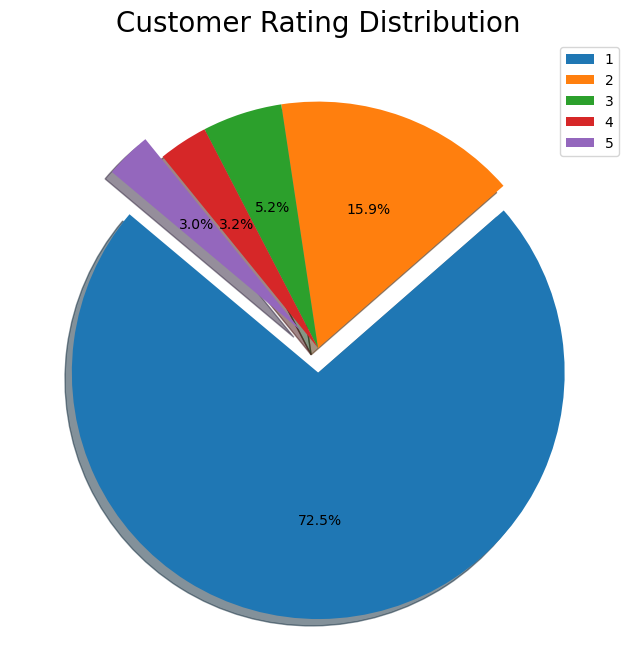

In [5]:
# Visualize the repartition of rating
plt.figure(figsize=(8, 8))

explode = [0.1, 0, 0, 0, 0.1]
plt.pie(data['rating'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '2', '3', '4','5'])
plt.title('Customer Rating Distribution', fontsize=20)
plt.axis('off');

In [6]:
# Define sentiment_r 0 if rating <= 3 and sentiment_r = 1 if rating >= 4
sentiment_r = 1*(data["rating"] >= 4).values 

# Define sentiment_rmc = -1 if rating <=2, = 1 if rating >= 4, else = 0
sentiment_rmc = (-1*(data["rating"] <= 2) + 1*(data["rating"] >= 4)).values

# insert sentiment_r and sentiment_rmc into the dataFrame data
#insert sentiment_r ast the 3rd column
data.insert(2, 'sentiment_r', sentiment_r)

# insert sentiment_rmc as the 4th column
data.insert(3, 'sentiment_rmc', sentiment_rmc)

data.head(2)

,id,rating,sentiment_r,sentiment_rmc,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,...,year_of_transaction,month_of_transaction,day_of_transaction,weekday_of_transaction,transaction_in_weekend,transaction_date,comment_length,log_comment_length,title_length,nb_days_before_review
0,rev-cc907a30-4fb0-4e55-a4a1-307b89eb0d99,4,1,1,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,...,2023,9,23,5,1,2023-09-23,1049,6.955593,7,12.0
1,rev-b54467c4-4769-42e3-a74a-c72c000059f9,4,1,1,Jolie table mais plus pour 6 que pour 8,Livraison impeccable avec possibilité de prend...,2023-10-02 13:08:27,2023-09-11,NaN,NaN,...,2023,9,11,0,0,2023-09-11,885,6.785588,39,21.0


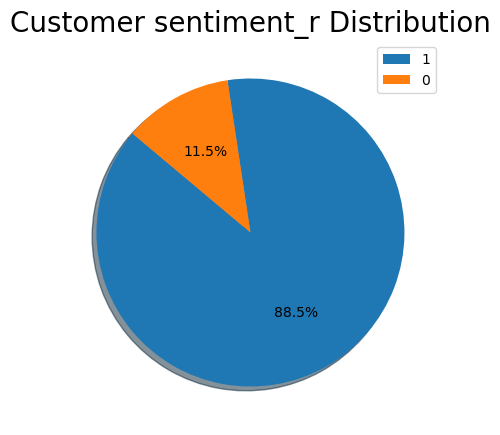

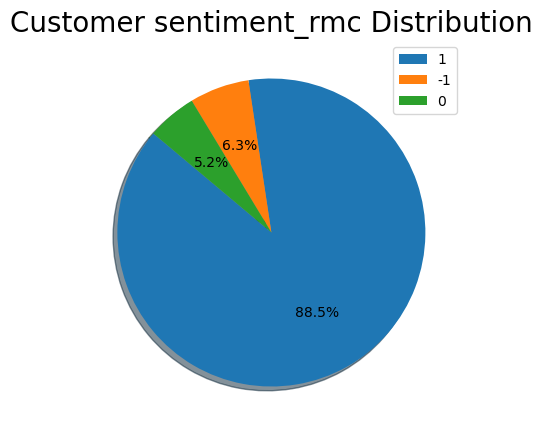

In [9]:
# plot sentiment_r repartition
plt.figure(figsize=(5, 5))

plt.pie(data['sentiment_r'].value_counts(), autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '0'])
plt.title('Customer sentiment_r Distribution', fontsize=20)
plt.axis('off');

# plot sentiment_rmc repartition
plt.figure(figsize=(5, 5))

plt.pie(data['sentiment_rmc'].value_counts(), autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '-1', '0'])
plt.title('Customer sentiment_rmc Distribution', fontsize=20)
plt.axis('off');

<b>Very unbalanced data</b>     

##  Text Mining

In [10]:
# stop words

added_stopwords = ["être", "leur", "leurs", "avoir", "cela", "les", "de", "pour", "des", "cette", "a",
                   "j'ai", "car", "c'est", "chez", "tout", "fait", "chez", "donc", 
                   "n'est", "si", "alors", "n'ai", "faire", "deux", "comme", "jour", "tr", "si", "ue"]

stop_words = set(stopwords.words('french'))  | set(added_stopwords) #| set(non_discrimant_words)

In [11]:
def clean_text(data):
    
    #1. Remove Puncs
    # \w typically matches [A-Za-z0-9_]
    text = re.sub('[^\w\s]',' ', data)
         
    #2. Tokenize
    text_tokens = word_tokenize(text.lower(), language='french') 
    
    #3. Remove punctuation
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #joining
    return " ".join(tokens_without_sw)

In [12]:
#text = clean_text(str(data["comment"]))
for i in range(5):
    print("i"+str(i), clean_text(data["comment"][i]))
    print("    ---")
    print(data["comment"][i])
    print("*****")


i0 facilte sollicitations dosées qualité pourrait cependant améliorer volet recap commandes appli moment livraison lorsque propres équipes intervenants autres communiquent rappel systématique contenu commande numéro redoute sociétés livraison code bien quand commande beaucoup modes livraison différents manière rythmes sportif ailleurs bien sociétés livraison quand elles livrent alignent look mails autres type communication vôtre service parfait bout bout concernant marques autres vôtres distribuez chargent livrer annoncez parfois dates livraison correspondent général livré avant certes achetons vois devriez informés elles dès vraies dates livraison redoute reste transparent
    ---
Facilte, sollicitations dosées...qualité..on pourrait cependant améliorer le volet recap commandes sur l'appli avec au moment de la livraison, lorsque vos propres équipes ou des intervenants autres communiquent avec nous un rappel systématique du contenu de la commande et son numéro la Redoute. Les sociétés 

In [13]:
data["comment_cleaned"] = data["comment"].apply(clean_text)
data["comment_cleaned"].head()


0    facilte sollicitations dosées qualité pourrait...
1    livraison impeccable possibilité prendre rdv s...
2    achat canapé redoute intérieurs site redoute a...
3    commande depuis longtemps redoute appréciais c...
4    habitude aucun souci rapidité expédition colis...
Name: comment_cleaned, dtype: object

In [14]:
# Dealing with rare words
all_words = " ".join(data["comment_cleaned"]).split()
print(len(all_words))

word_values = pd.Series(all_words).value_counts()
rare_words = word_values[word_values <= 2]
print(len(rare_words))
rare_words

190195
7045


mien            2
contraignant    2
maintenu        2
stress          2
pliés           2
               ..
creneau         1
jamis           1
deplorable      1
duperie         1
pietre          1
Name: count, Length: 7045, dtype: int64

In [15]:
# Remove all rare words
rare_words.index
data["comment_cleaned"] = data["comment_cleaned"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
data["comment_cleaned"].head()

0    qualité pourrait cependant améliorer commandes...
1    livraison impeccable possibilité prendre rdv s...
2    achat canapé redoute intérieurs site redoute a...
3    commande depuis longtemps redoute choix rapidi...
4    habitude aucun souci rapidité expédition colis...
Name: comment_cleaned, dtype: object

In [16]:
# Dealing with  remaining  line m of df["comment_cleaned"] where len(line)= 0
count = 0
for i, s in enumerate(data["comment_cleaned"]):
    if len(s) == 0:
        print("i:"+ str(i))
        count = count + 1
print("total:", count)


i:2355
i:2760
i:2764
i:2830
i:2897
i:2969
i:2995
i:3013
i:3047
i:3066
i:3097
i:3107
i:3111
i:3112
i:3118
i:3120
i:3149
i:3151
i:3152
i:3153
i:3154
i:3155
i:3156
i:5502
i:5677
i:5872
i:5885
i:5887
i:5888
i:5891
i:5894
i:5907
i:5909
i:6228
i:6231
i:8251
i:8252
i:8254
i:8270
i:8271
i:8272
i:8273
i:8274
i:8275
i:8276
i:8277
i:8278
i:8574
i:10578
i:10912
i:10917
i:10919
i:10920
i:10925
i:10941
i:10942
i:16502
i:21135
i:21233
i:21256
i:21262
i:21299
i:21301
i:21317
i:21353
i:21468
i:21508
i:21568
i:21677
i:21687
i:21696
i:21741
i:21833
i:21885
i:21938
i:21940
i:21942
i:21952
i:21955
i:21956
i:21958
i:21962
i:21963
i:21964
i:21968
i:21977
i:21979
i:21981
i:21985
i:21991
i:21992
i:21995
i:21996
i:22000
i:22003
i:22004
i:22006
i:22007
i:22013
i:22015
i:22017
i:22022
i:22035
i:22057
i:22058
i:22070
i:22072
i:22075
i:22085
i:22087
i:22089
i:22104
i:22105
i:22106
i:22107
i:22108
i:22109
i:22110
i:22111
i:22112
i:22113
i:22115
i:22116
i:22117
i:22118
i:22119
i:22120
i:22121
i:22122
i:22123
i:22125


In [19]:

# use SPACY
nlp = spacy.load('fr_core_news_md')

# function to to apply stemming
stemmer = SnowballStemmer(language='french')
def return_stem(texte):
    doc = nlp(texte)
    return ' '.join([stemmer.stem(word.text) for word in doc])

# apply stemming to comment_cleaned
data["comment_stem"] = data["comment_cleaned"].apply(lambda x: return_stem(x))

# remove lines with comment_stem length of zero
data["length"] = data["comment_stem"].apply(lambda x: len(x))
data = data[data["length"] > 0]

In [22]:
# remove lines where comment_cleaned length is equal to 0.
data["length"] = data["comment_cleaned"].apply(lambda x: len(x))

#remove line with comment_cleaned length zero 
data = data[data["length"] > 0]

# select relevant data for our model
df = data[["comment", "comment_cleaned", "comment_stem", "rating", "sentiment_r", "sentiment_rmc"]]
display(df.head())
print(df.info())

# save data to "data_for_rnn.csv"
df.to_csv("data_for_rnn.csv")


,comment,comment_cleaned,comment_stem,rating,sentiment_r,sentiment_rmc
0,"Facilte, sollicitations dosées...qualité..on p...",qualité pourrait cependant améliorer commandes...,qualit pourr cepend amélior command appli mome...,4,1,1
1,Livraison impeccable avec possibilité de prend...,livraison impeccable possibilité prendre rdv s...,livraison impecc possibil prendr rdv samed mat...,4,1,1
2,Achat d'un canapé La Redoute intérieurs le 6/9...,achat canapé redoute intérieurs site redoute a...,achat canap redout intérieur sit redout abord ...,4,1,1
3,je commande depuis longtemps chez la redoute; ...,commande depuis longtemps redoute choix rapidi...,command depuis longtemp redout choix rapid liv...,4,1,1
4,"Comme d'habitude, aucun souci et rapidité d'ex...",habitude aucun souci rapidité expédition colis...,habitud aucun souc rapid expédit colis bravo d...,5,1,1


<class 'pandas.core.frame.DataFrame'>
Index: 23336 entries, 0 to 23468
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          23336 non-null  object
 1   comment_cleaned  23336 non-null  object
 2   comment_stem     23336 non-null  object
 3   rating           23336 non-null  int64 
 4   sentiment_r      23336 non-null  int64 
 5   sentiment_rmc    23336 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.2+ MB
None


In [23]:
#word cloud
from wordcloud import WordCloud
from PIL import Image

def plot_word_cloud(text, title, background_color = "white"):
    # Définir un masque
    # mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=500, 
                   stopwords=stop_words,  
                   max_font_size=90, random_state=42)
    # Générer et afficher le nuage de mots
    plt.figure(figsize= (8,6))
    wc.generate(text)
    plt.title(title)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()



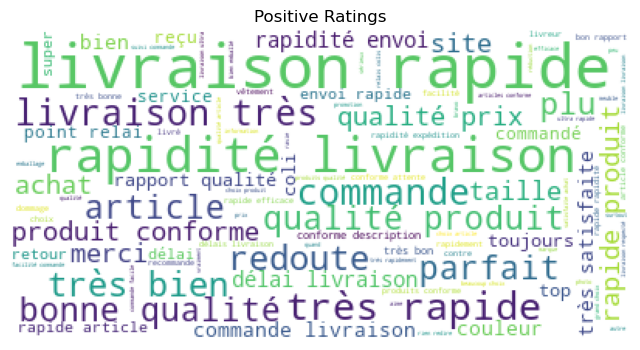

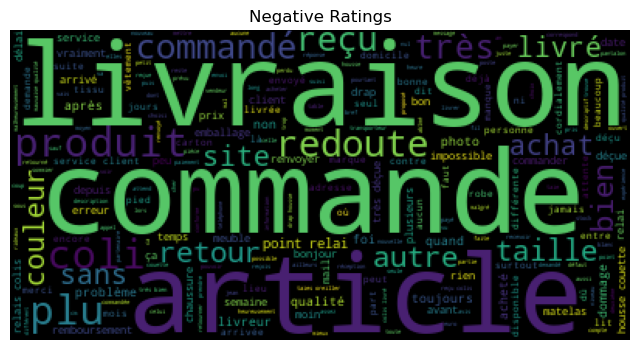

In [24]:
# in case of binary calssification
positive_comments = ' '.join(data[data["rating"]>=4]["comment_cleaned"])
negative_comments = ' '.join(data[data["rating"]<=3]["comment_cleaned"])

plot_word_cloud(positive_comments, "Positive Ratings", background_color = "white")
plot_word_cloud(negative_comments, "Negative Ratings", background_color = "black")

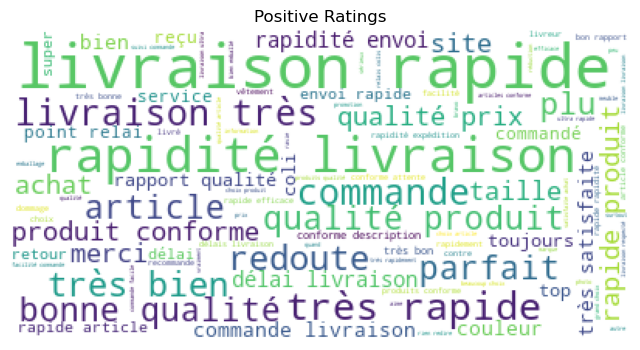

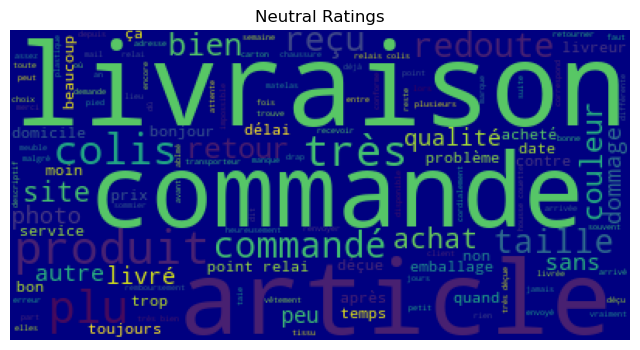

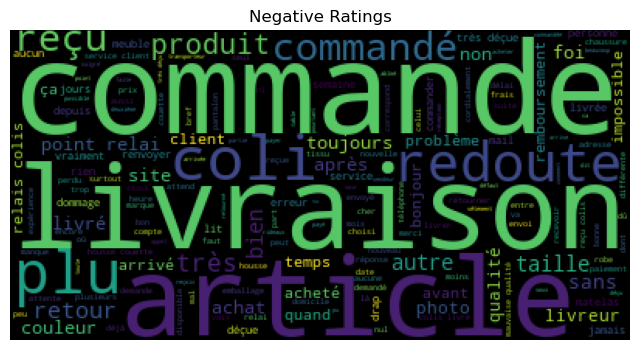

In [48]:
# case of multiclass negative, neutral and positive rating
positive_comments = ' '.join(data[data["rating"]>3]["comment_cleaned"])
neutral_comments = ' '.join(data[data["rating"]==3]["comment_cleaned"])
negative_comments = ' '.join(data[data["rating"]<3]["comment_cleaned"])

plot_word_cloud(positive_comments, "Positive Ratings", background_color = "white")
plot_word_cloud(neutral_comments, "Neutral Ratings", background_color = "navy")
plot_word_cloud(negative_comments, "Negative Ratings", background_color = "black")

## Conclusion and next step.
- "comment_cleaned" column is now ready for tokenization, numerization and padding for use in a neural network model
- The processed data have been saved in "data_for_rnn.csv"